In [6]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os, shutil

# Extract the dataset from Drive
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

print("✅ Dataset extracted successfully!")

Mounted at /content/drive
✅ Dataset extracted successfully!


In [7]:
import os, shutil

def rename_folders(base_dir):
    for crop in os.listdir(base_dir):
        crop_path = os.path.join(base_dir, crop)
        if not os.path.isdir(crop_path):
            continue

        for condition in os.listdir(crop_path):
            old_path = os.path.join(crop_path, condition)
            if not os.path.isdir(old_path):
                continue

            new_folder_name = f"{crop}_{condition}"
            new_path = os.path.join(base_dir, new_folder_name)

            if os.path.exists(new_path):
                for file in os.listdir(old_path):
                    shutil.move(os.path.join(old_path, file), new_path)
                os.rmdir(old_path)
            else:
                shutil.move(old_path, new_path)

        if not os.listdir(crop_path):
            os.rmdir(crop_path)

base_dir = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"
rename_folders(base_dir)
print("✅ Dataset folders renamed successfully!")


✅ Dataset folders renamed successfully!


In [8]:
import os
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile   # 👈 add this
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 👇 add this line here
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
IMAGE_SIZE = 224
PATCH_SIZE = 16

In [10]:


# Verify Images Function
def verify_images(directory):
    broken_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f" Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images

In [11]:
# Train/Validation Split (fixed to stay inside dataset folder)
def split_dataset(base_dir, val_ratio=0.15):
    val_base_dir = os.path.join(base_dir, "Validation")

    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        if cls == "Validation":  # skip if Validation already exists
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            print(f"⚠ No images found in {cls_path}")
            continue

        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        # Create validation dir for this class
        val_dir = os.path.join(val_base_dir, cls)
        os.makedirs(val_dir, exist_ok=True)

        # Move validation images
        for img in val_imgs:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_dir, img))

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")

In [12]:
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [14]:
   # Load Dataset
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, train_dataset.classes

In [15]:
# Convert Image Batch to ViT Patches
def image_to_patches(img_batch, patch_size):
    B, C, H, W = img_batch.shape  # Batch Size, Channels, Height, Width
    patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(B, -1, C * patch_size * patch_size)
    return patches  # Shape: (Batch, Num_Patches, Flattened Patch Size)

In [16]:
# Display Sample Images with Patches
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        std_tensor = torch.tensor(std_vals).view(3, 1, 1)
        mean_tensor = torch.tensor(mean_vals).view(3, 1, 1)
        img = img * std_tensor + mean_tensor  # Reverse normalization
        return img.clamp(0, 1)  # Clip values between 0-1

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i in range(8):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()
# Convert to Patches for ViT
    patches = image_to_patches(images, PATCH_SIZE)
    print(f"Patches Shape: {patches.shape}")  # (Batch, Num_Patches, Flattened Patch Size)

# Run Pipeline
dataset_path = "/content/Dataset for Crop Pest and Disease Detection"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm # Import timm here
from torch.utils.data import random_split # Import random_split
import os # Import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalization values (standard for ImageNet)
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

# Image preprocessing (using transforms defined earlier for consistency)
# Assuming train_transforms are suitable for both train and test for initial loading
IMAGE_SIZE = 224 # Define IMAGE_SIZE here
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals) # Using mean_vals and std_vals defined earlier
])

# Dataset paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Check if the dataset directory exists
if not os.path.exists(dataset_root):
    print(f"Error: Dataset directory not found at {dataset_root}")
else:
    # Load full dataset to split
    full_dataset = datasets.ImageFolder(dataset_root, transform=transform)

    class_names = full_dataset.classes
    print("Class Labels:", class_names)

    num_classes = len(full_dataset.classes)

    # Load pretrained MobileViT from timm
    model = timm.create_model("mobilevit_xxs", pretrained=True, num_classes=num_classes)
    model.to(device)

    # Dataloaders (Splitting the full dataset into train and test)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size]) # Using test_dataset for consistency with the rest of the code

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("✅ Model and DataLoaders initialized successfully!")

    # Train and evaluate the model
    # Removed the calls to train_model and evaluate_model from here

Class Labels: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

✅ Model and DataLoaders initialized successfully!


In [18]:
# Clean dataset from corrupt images
corrupt_files = verify_images(dataset_path)
if corrupt_files:
    print(f"⚠ Found {len(corrupt_files)} corrupt images. Removing them...")
    for f in corrupt_files:
        try:
            os.remove(f)
            print(f"Removed: {f}")
        except Exception as e:
            print(f"Error removing {f}: {e}")
else:
    print("✅ No corrupt images found!")

# Rebuild datasets and loaders after cleanup
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print("✅ Dataloaders rebuilt successfully")

 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus774_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus774_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus119_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus119_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus422_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus422_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_streak virus/streak virus998_.jpg | Error: 

Verifying images...
All images verified successfully.
Classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


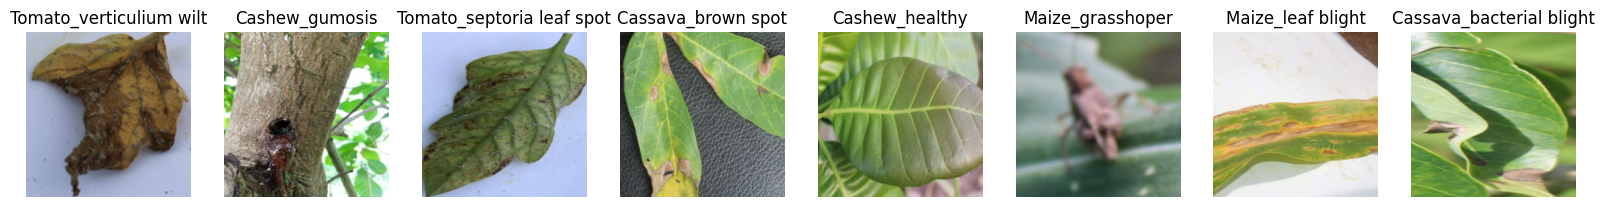

Patches Shape: torch.Size([8, 196, 768])


In [19]:
# Define paths
dataset_path = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Verify images before processing
print("Verifying images...")
broken_images = verify_images(dataset_path)
if broken_images:
    print(f"Found {len(broken_images)} broken images. Consider removing them.")
    # Optionally add code here to remove or quarantine broken_images
else:
    print("All images verified successfully.")

# Train/Validation split handled automatically by torch.utils.data.random_split
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

# Show a sample batch
imshow_batch(train_loader, class_names)

In [20]:
!pip install -q torch torchvision torchaudio tqdm scikit-learn matplotlib

import os, random, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


In [21]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)


🚀 Using device: cuda


In [22]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Use the datasets created in cell BtKYEQSKi07R
# train_dir = os.path.join(extract_path, 'train')
# val_dir   = os.path.join(extract_path, 'val')
# test_dir  = os.path.join(extract_path, 'test')

# train_dataset = ImageFolder(train_dir, transform=train_transform)
# val_dataset   = ImageFolder(val_dir, transform=val_test_transform)
# test_dataset  = ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = full_dataset.classes # Use class names from the full dataset
print("✅ Classes:", class_names)
print(f"📊 Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

✅ Classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']
📊 Train: 20136 | Val: 5034 | Test: 5044


In [23]:
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print("✅ Model loaded and ready for training!")


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 112MB/s]


✅ Model loaded and ready for training!


In [28]:
EPOCHS = 10
best_val_acc = 0.0
save_path = '/content/efficientnetv2_ccmt_best.pth'

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss/len(pbar)})
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    scheduler.step(val_acc)

    print(f"📈 Epoch {epoch}: TrainLoss={avg_train_loss:.4f} | ValAcc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved (ValAcc={val_acc:.4f})")


Epoch 1/10: 100%|██████████| 630/630 [05:06<00:00,  2.06it/s, loss=0.116]


📈 Epoch 1: TrainLoss=0.1164 | ValAcc=0.9090
💾 Best model saved (ValAcc=0.9090)


Epoch 2/10: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=0.0866]


📈 Epoch 2: TrainLoss=0.0866 | ValAcc=0.9118
💾 Best model saved (ValAcc=0.9118)


Epoch 3/10: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=0.083]


📈 Epoch 3: TrainLoss=0.0830 | ValAcc=0.9108


Epoch 4/10: 100%|██████████| 630/630 [05:08<00:00,  2.04it/s, loss=0.0668]


📈 Epoch 4: TrainLoss=0.0668 | ValAcc=0.9070


Epoch 5/10: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=0.0616]


📈 Epoch 5: TrainLoss=0.0616 | ValAcc=0.9086


Epoch 6/10: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=0.0559]


📈 Epoch 6: TrainLoss=0.0559 | ValAcc=0.9056


Epoch 7/10: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=0.0508]


📈 Epoch 7: TrainLoss=0.0508 | ValAcc=0.9060


Epoch 8/10: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=0.0499]


📈 Epoch 8: TrainLoss=0.0499 | ValAcc=0.9120
💾 Best model saved (ValAcc=0.9120)


Epoch 9/10: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=0.044]


📈 Epoch 9: TrainLoss=0.0440 | ValAcc=0.9098


Epoch 10/10: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=0.043]


📈 Epoch 10: TrainLoss=0.0430 | ValAcc=0.9058


In [29]:
# ✅ Evaluate Total Accuracy
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader # Import DataLoader here

# Rebuild the test loader after removing corrupt images
# Assuming full_dataset, train_size, and val_size are defined in previous cells
# and that the corrupt images have been removed from the dataset directory
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
# We are only interested in the test set for evaluation
_, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # Recreate test_loader

# Load the best model weights
model.load_state_dict(torch.load(save_path, map_location=device))


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Total Test Accuracy: {accuracy * 100:.2f}%")


✅ Total Test Accuracy: 97.56%


In [30]:
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n✅ Testing complete!")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Testing: 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]



✅ Testing complete!
                           precision    recall  f1-score   support

       Cashew_anthracnose     1.0000    0.9972    0.9986       363
           Cashew_gumosis     1.0000    0.9773    0.9885        88
           Cashew_healthy     1.0000    1.0000    1.0000       290
        Cashew_leaf miner     0.9930    1.0000    0.9965       285
          Cashew_red rust     1.0000    1.0000    1.0000       335
 Cassava_bacterial blight     0.9981    0.9870    0.9925       538
       Cassava_brown spot     0.9786    0.9964    0.9874       276
       Cassava_green mite     0.9853    0.9950    0.9901       202
          Cassava_healthy     1.0000    1.0000    1.0000       233
           Cassava_mosaic     0.9958    0.9917    0.9937       240
      Maize_fall armyworm     0.9552    0.9697    0.9624        66
         Maize_grasshoper     0.9847    0.9923    0.9885       130
            Maize_healthy     0.9302    0.9756    0.9524        41
        Maize_leaf beetle     0.9940    

Enter leaf image paths (comma separated): cassava-mosaic-disease-manioc-1561129470.jpg,images (1).jpeg,leaf-spot-of-maize-maize-1575459018.jpg,images.jpeg


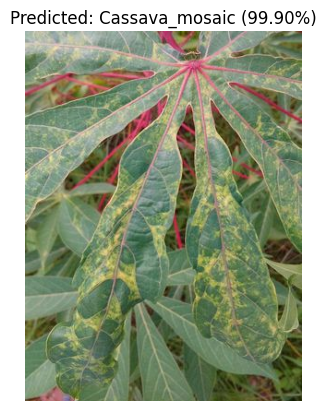


Top-3 Predictions for cassava-mosaic-disease-manioc-1561129470.jpg:
Cassava_mosaic       : 99.90%
Maize_leaf blight    : 0.04%
Cassava_green mite   : 0.02%


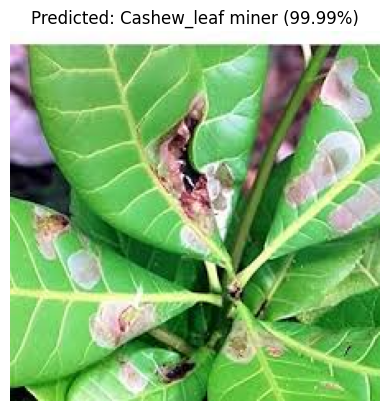


Top-3 Predictions for images (1).jpeg:
Cashew_leaf miner    : 99.99%
Cassava_brown spot   : 0.00%
Cassava_bacterial blight : 0.00%


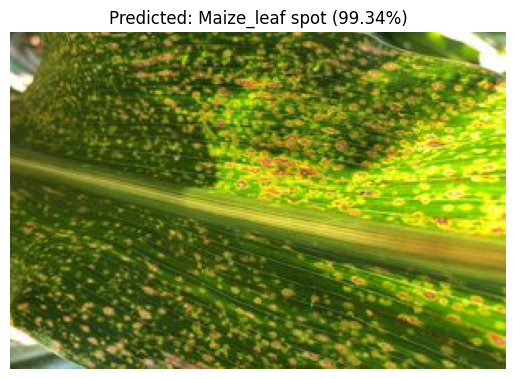


Top-3 Predictions for leaf-spot-of-maize-maize-1575459018.jpg:
Maize_leaf spot      : 99.34%
Maize_streak virus   : 0.64%
Maize_healthy        : 0.02%


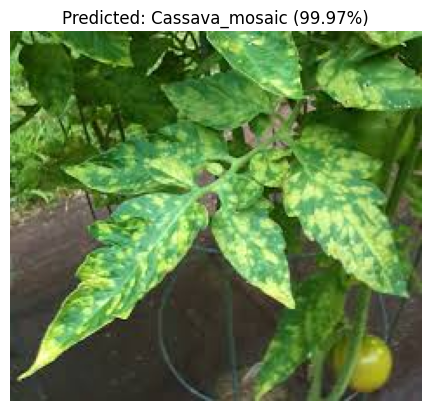


Top-3 Predictions for images.jpeg:
Cassava_mosaic       : 99.97%
Tomato_leaf curl     : 0.02%
Tomato_septoria leaf spot : 0.01%


In [31]:
# -----------------------------
# ✅ Step 8: Predict on Multiple Images
# -----------------------------
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Make sure class_names and device are already defined
# Example: class_names = train_data.classes

def predict_images(image_paths):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    model.eval()

    for image_path in image_paths:
        try:
            img = Image.open(image_path).convert('RGB')
            x = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(x)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
                pred_idx = np.argmax(probs)
                pred_class = class_names[pred_idx]

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted: {pred_class} ({probs[pred_idx]*100:.2f}%)")
            plt.show()

            print(f"\nTop-3 Predictions for {image_path}:")
            for i in np.argsort(probs)[-3:][::-1]:
                print(f"{class_names[i]:20s} : {probs[i]*100:.2f}%")

        except FileNotFoundError:
            print(f"Error: Image not found at {image_path}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# 🔹 Input Block
image_paths_input = input("Enter leaf image paths (comma separated): ")
image_paths_to_predict = [path.strip() for path in image_paths_input.split(',')]
predict_images(image_paths_to_predict)